

[
  
  # Problemas








  dadawdawdadawdaadwadadawdadwadwdwsssssss
Como vimos acima, há muitos passos na criação e definição de uma nova rede neural.
A grande parte desses ajustes dependem diretamente do problemas.

Abaixo, listamos alguns problemas. Todos os problemas e datasets usados vem do [Center for Machine Learning and Intelligent Systems](http://archive.ics.uci.edu/ml/datasets.php).


**Seu objetivo é determinar e implementar um modelo para cada problema.**

Isso inclui:

1. definir uma arquitetura.
Por enquanto usando somente camadas [Lineares](https://pytorch.org/docs/stable/nn.html#linear), porém podemos variar as ativações, como [Sigmoid](https://pytorch.org/docs/stable/nn.html#sigmoid), [Tanh](https://pytorch.org/docs/stable/nn.html#tanh), [ReLU](https://pytorch.org/docs/stable/nn.html#relu), [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html), [ELU](https://pytorch.org/docs/stable/generated/torch.nn.ELU.html), [SeLU](https://pytorch.org/docs/stable/generated/torch.nn.SELU.html), [PReLU](https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html), [RReLU](https://pytorch.org/docs/stable/generated/torch.nn.RReLU.html)
2. definir uma função de custo. Algums opções que vimos previamente incluem[L1](https://pytorch.org/docs/stable/nn.html#l1loss), [L2/MSE](https://pytorch.org/docs/stable/nn.html#mseloss), [Huber/SmoothL1](https://pytorch.org/docs/stable/nn.html#smoothl1loss), [*Cross-Entropy*](https://pytorch.org/docs/stable/nn.html#crossentropyloss), [Hinge](https://pytorch.org/docs/stable/nn.html#hingeembeddingloss)), e
3. definir um algoritmo de otimização ([SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD), [RMSProp](https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop), [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam))

A leitura do dado assim como a função de treinamento já estão implementados para você.

# Preâmbulo

In [ ]:
# imports basicos
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torchvision

from torchvision import datasets, transforms
from torch import optim, nn

import os
import sys
import time
import numpy as np

from sklearn.preprocessing import StandardScaler

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

In [ ]:
# Test if GPU is avaliable, if not, use cpu instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = torch.cuda.device_count()
devices_ids = list(range(n))
device

device(type='cpu')

## Funções básicas

Use a função `load_array ` declarada a seguir se voce ja tem os dados armazenados em um **array** (por exemplo um array do numpy, o `np.array`). Pode acontecer de que os nossos dados vêm simplesmente de um dataset que pode ser armazennado em um array, e portanto não é necessário fazer os outros passos mais complicados como carregar os dados do disco, etc; basta que possamos recuperar esses dados em *batches* aleatórios. O resultado dessa função é um `DataLoader` do Pytorch com os dados que fornecemos de entrada, e que permite que os acessamos da seguinte forma:

```python
data_loader = load_array(X, y, batch_size=32, is_train=True)
for x_batch, y_batch in data_loader:
    ### ... nossa iteração de treinamento aqui.
```

Essa função recebe como parâmetro os seguintes valores:

- `features`: um array que contém as features de todas as instâncias do dataset. Por exemplo, no caso do MNIST seria um array de tamanho `(60000, 28, 28, 1)` com todas as imagens do dataset de treino.
- `labels`: um array que contém os rótulos de cada instância de dados. No caso do MNIST, seria um array de tamanho `(60000,)` em que a posição `i` contém o rótulo do dígito da posição `i` do array `features`.
- `batch_size`: tamanho do batch desejado
- `is_train`: um booleano que indica se o dataset que estamos criando é o conjunto de treinamento ou não (conjunto de teste). A única mudança que isso causa no `Dataloader` resultante é que se for o conjunto de treinamento ele cria batches aleatórios.


In [ ]:
def load_array(features, labels, batch_size, is_train=True):
    """Construct a Torch data loader"""

    ## transform the input arrays in a tensor in case they are not
    if type(features) != torch.tensor:
        features = torch.tensor(features)
    if type(labels) != torch.tensor:
        labels = torch.tensor(labels)

    ## create a Pytorch Dataset and DataLoader with the input data
    dataset = torch.utils.data.TensorDataset(features, labels)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

Use a função `evaluate_accuracy` para calcular a acurácia e a *loss-function* para a rede em um conjunto de dados. Note que essa função pode ser usada tanto para avaliar a rede no conjunto de teste (no caso que usamos o `DataLoader` de teste) quanto o conjunto de treinamento (se usamos o `DataLoader` de treinamento). Os parâmetros são:
- `data_iter`: um `DataLoader` que contém os dados que queremos usar para avaliar a rede. Repare que esse parâmetro tipicamente é o ojeto que obtemos como saída da função `load_array` para montar o nosso `DataLoader`.
- `net`: a rede que queremos avaliar
- `loss`: a nossa *loss-function*. Pode ser um objeto de qualquer uma das funções de perda que mencionamos acima no começo do notebook.

O resultado dessa função é uma tupla em que o primeiro valor é a acurácia e o segundo a função de custo calculados.

In [ ]:
# Função usada para calcular acurácia
def evaluate_accuracy(data_iter, net, loss):
    """Evaluate accuracy of a model on the given data set."""

    ## valores "acumuladores", que guardam a soma de, respectivamente, quantas instâncias
    ## prevemos corretamente, quantas instâncias percorremos no dataset, e o valor da loss; para
    ## todos os batches
    acc_sum, n, l = 0, 0, 0

    ## muda a rede para o "modo de teste". O que isso faz é mudar o comportamento de alguns módulos da rede,
    ## como os módulos de Dropout e BatchNorm, que funcionam de forma diferente quando estamos treinando ou
    ## quando estamos avaliando (ou usando em produção) a rede
    net.eval()

    with torch.no_grad():
      for X, y in data_iter:
          X, y = X.to(device), y.to(device)
          y_hat = net(X)
          l += loss(y_hat, y.long())

          ## aqui estamos calculando a quantidade de previsões que temos correta para o batch atual. o resultado
          ## do argmax é a posição de `y_hat` que possui o maior valor. Consequentemente isso resulta na classe que
          ## a rede deu o maior score.
          acc_sum += (y_hat.argmax(axis=1) == y).sum().item()

          ##
          n += y.size(0)

    return acc_sum / n, l.item() / len(data_iter)

A função `train_validate` é a função que implementa nossas iterações de treinamento padrão. Ela ja faz o trabalho de percorrer o dataset inteiro para cada época, e também de tempos em tempos avaliar a rede e mostar os resultados na tela. Para isso ela faz chamadas à função `evaluate_accuracy` declarada anteriormente (entre outras coisas). Essa função tem os segugintes parâmetros:
- `net`: a rede que queremos treinar
- `train_iter` e `test_iter`: nossos `DataLoaders` que criamos para acessar os dados. Esses DataLoaders podem ser criados com a função `load_array` declarada acima.
- `trainer`: é o nosso otimizador. Podemos usar aqui qualquer um dos otimizadores que escolhermos da lista citada no começo desse notebook.
- `loss`: a loss function que escolhemos para otimizar. Pode ser qualquer um das funções de custo citadas no começo do notebook.
- `num_epochs`: a quantidade de épocas pelas quais queremos que o treinamento ocorra.
- `type`: o tipo de tarefa que estamos lidando. Se for um problema de regressão, usamos `type='regression'`, e se for um problema de classificação, usamos `type='classification'`. Esse parâmetro é necessário para a função, por exemplo, saber quais métricas ele vai mostrar (acurácia, ou apenas o MSE, etc.)

Código antigo

In [ ]:
# Função usada no treinamento e validação da rede
def train_validate_antigo(net, train_iter, test_iter, trainer, loss, num_epochs, type='regression'):
    print('training on', device)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            if type == 'regression':
              l = loss(y_hat, y.float())
            else:
              l = loss(y_hat, y.long())
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.size(0)
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss)
        if type == 'regression':
          print('epoch %d, train loss %.4f, test loss %.4f, time %.1f sec'
                % (epoch + 1, train_l_sum / len(train_iter), test_loss, time.time() - start))
        else:
          print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, '
              'test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / len(train_iter), train_acc_sum / n, test_loss,
                 test_acc, time.time() - start))


Código Novo


In [ ]:
def train_validate(net, train_iter, test_iter, trainer, loss, num_epochs, type='regression'):
    print('training on', device)
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            if type == 'regression':
                l = loss(y_hat, y.float())
            else:
                l = loss(y_hat, y.long())
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.size(0)

        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss)
        avg_train_loss = train_l_sum / len(train_iter)
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss)

        if type == 'regression':
            print('epoch %d, train loss %.4f, test loss %.4f, time %.1f sec'
                  % (epoch + 1, avg_train_loss, test_loss, time.time() - start))
        else:
            print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, '
                  'test acc %.3f, time %.1f sec'
                  % (epoch + 1, avg_train_loss, train_acc_sum / n, test_loss,
                     test_acc, time.time() - start))

    # Plotando gráfico de loss
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss por Época')
    plt.legend()
    plt.grid(True)
    plt.show()

Use a função a seguir para inicializar os pesos da rede. Ela recebe como parâmetro um módulo da rede neural, e se for uma camada linear ele inicializa os pesos e os bias dessa camada. Embora possa parecer complicado de precisar chamar essa função para todas as camadas lineares da nossa rede, o módulos do Pytorch (que incluem tanto as redes criadas com o `nn.Sequential` ou com `nn.Module`) possuem a função `net.apply()` que recebe como parâmetro uma função e aplica ela a todos os submódulos da rede. Portanto, depois de ter criado a nossa rede, podemos chamar:

```python
net.apply(weights_init)
```
que automaticamente todas as camadas `nn.Linear` serão inicializadas. Caso queira saber mais sobre o `.apply()`, veja o seguinte [link](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply).

In [ ]:
# Função para inicializar pesos da rede
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 0.01) # valores iniciais são uma normal
        m.bias.data.fill_(0)

# Problema 1

Neste problema, você receberá 14 *features* coletadas de pacientes e tentará predizer se eles tem algum sinal de doença cardíaca. Mais sobre esse dataset aqui: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [ ]:
## aqui fazemos o download do dataset usando o `!wget`. Se estamos rodando em um servidor linux (como é o caso do Colab),
## podemos usar comandos do linux precedidos pelo "!". Por exemplo podemos fazer !ls para listar os arquivos da instância do colab.
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

## aqui fazemos um tratamento inicial dos dados. "np.genfromtxt" lê os dados de um arquivo .txt e transforma em
## um array. Pode ser interessante abrir o arquivo para verificar como os dados chegaram. Se estiver no colab, voce
## pode verificar o arquivo "processed.cleveland.data" clicando na pastinha do canto esquerdo da página. a função
## "np.nan_to_num" trata valores NaN e infinitos no dataset.
data = np.genfromtxt('processed.cleveland.data', delimiter=',', dtype=np.float32)
data = np.nan_to_num(data)

--2025-05-19 12:56:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘processed.cleveland.data’

processed.cleveland     [ <=>                ]  18.03K  --.-KB/s    in 0.1s    

2025-05-19 12:56:23 (140 KB/s) - ‘processed.cleveland.data’ saved [18461]



In [ ]:
## aqui separamos os dados entre features (X) e rótulo (y), e depois separamos em um conjunto de treinamento e teste
print(data.shape, data[0, :])
X, y = data[:, :-1], data[:, -1]
print(X.shape, X[0, :])
print(y.shape, y[0])
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.20, random_state=42)

(303, 14) [ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   6.    0. ]
(303, 13) [ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   6. ]
(303,) 0.0


In [ ]:
## aqui criamos nossos DataLoaders para conseguirmos iterar nos dados
batch_size = 64
train_iter = load_array(train_features, train_labels, batch_size)
test_iter = load_array(test_features, test_labels, batch_size, False)

Regularização

In [ ]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

train_iter = load_array(train_features, train_labels, batch_size)
test_iter = load_array(test_features, test_labels, batch_size, False)

training on cpu
epoch 1, train loss 1.6061, train acc 0.215, test loss 1.6093, test acc 0.197, time 0.1 sec
epoch 2, train loss 1.6091, train acc 0.463, test loss 1.6091, test acc 0.475, time 0.0 sec
epoch 3, train loss 1.6089, train acc 0.558, test loss 1.6089, test acc 0.475, time 0.0 sec
epoch 4, train loss 1.6086, train acc 0.558, test loss 1.6086, test acc 0.475, time 0.0 sec
epoch 5, train loss 1.6083, train acc 0.558, test loss 1.6084, test acc 0.475, time 0.0 sec
epoch 6, train loss 1.6080, train acc 0.558, test loss 1.6082, test acc 0.475, time 0.0 sec
epoch 7, train loss 1.6077, train acc 0.558, test loss 1.6080, test acc 0.475, time 0.0 sec
epoch 8, train loss 1.6074, train acc 0.558, test loss 1.6077, test acc 0.475, time 0.0 sec
epoch 9, train loss 1.6072, train acc 0.558, test loss 1.6075, test acc 0.475, time 0.0 sec
epoch 10, train loss 1.6069, train acc 0.558, test loss 1.6073, test acc 0.475, time 0.0 sec
epoch 11, train loss 1.6066, train acc 0.558, test loss 1.6071,

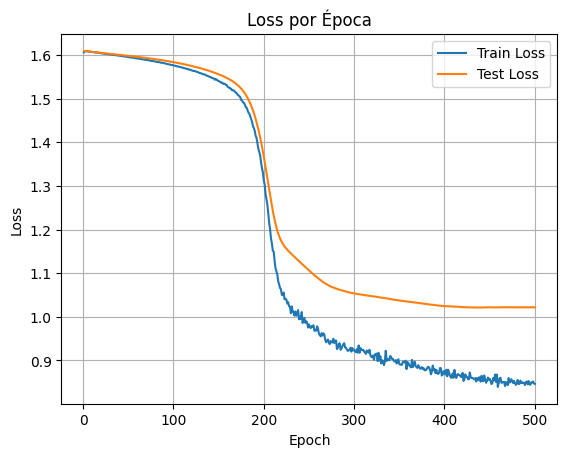

In [ ]:
# IMPLEMENTE AQUI

lr = 0.0001
epocas = 500
dropout = 0.5
weight_dc = 0.01

modelo = nn.Sequential(
    nn.Linear(13, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(64, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(32, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(16, 5),
).to(device)

modelo.apply(weights_init)

loss = nn.CrossEntropyLoss() # Softmax Inclusa
opt = torch.optim.Adam(modelo.parameters(), lr=lr, weight_decay=weight_dc)

train_validate(modelo, train_iter, test_iter, opt, loss, num_epochs=epocas, type='classification')

# Problema 2

Neste problema, você receberá 90 *features* extraídas de diversas músicas (datadas de 1922 até 2011) e deve predizer o ano de cada música. Mais sobre esse dataset aqui: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD

In [ ]:
# download do dataset
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
!unzip YearPredictionMSD.txt.zip
data = np.genfromtxt('YearPredictionMSD.txt', delimiter=',', dtype=np.float32)

print(data[0, :])
X, y = data[:, 1:], data[:, 0]
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.33, random_state=42)

batch_size = 100
train_iter = load_array(train_features, train_labels, batch_size)
test_iter = load_array(test_features, test_labels, batch_size, False)

--2025-05-19 12:56:30--  http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘YearPredictionMSD.txt.zip’

YearPredictionMSD.t     [ <=>                ] 201.24M  25.4MB/s    in 9.4s    

2025-05-19 12:56:39 (21.5 MB/s) - ‘YearPredictionMSD.txt.zip’ saved [211011981]

Archive:  YearPredictionMSD.txt.zip
  inflating: YearPredictionMSD.txt   
[ 2.0010000e+03  4.9943569e+01  2.1471140e+01  7.3077499e+01
  8.7486095e+00 -1.7406281e+01 -1.3099050e+01 -2.5012020e+01
 -1.2232570e+01  7.8308902e+00 -2.4678299e+00  3.3213601e+00
 -2.3152101e+00  1.0205560e+01  6.1110913e+02  9.5108960e+02
  6.9811426e+02  4.0898486e+02  3.8370911e+02  3.2651511e+02
  2.3811327e+02  2.5142413e+02  1.8717351e+02  1.0042652e+02
  1.7919498e+02 -8

In [ ]:
scaler = StandardScaler()

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.10, random_state=42)

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

train_iter = load_array(train_features, train_labels, batch_size)
test_iter = load_array(test_features, test_labels, batch_size, False)

In [ ]:
print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

(463810, 90) (463810,)
(51535, 90) (51535,)


training on cpu


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

epoch 1, train loss 747.5259, test loss 423.6084, time 15.6 sec
epoch 2, train loss 124.8945, test loss 119.2330, time 16.1 sec
epoch 3, train loss 120.5463, test loss 118.2309, time 15.2 sec
epoch 4, train loss 119.9898, test loss 117.9722, time 15.3 sec
epoch 5, train loss 119.8369, test loss 117.8713, time 15.1 sec
epoch 6, train loss 119.8447, test loss 117.8536, time 15.2 sec
epoch 7, train loss 119.7637, test loss 117.8238, time 16.1 sec
epoch 8, train loss 119.7322, test loss 117.8246, time 15.2 sec
epoch 9, train loss 119.7226, test loss 117.7959, time 15.2 sec
epoch 10, train loss 119.7430, test loss 117.8170, time 15.1 sec


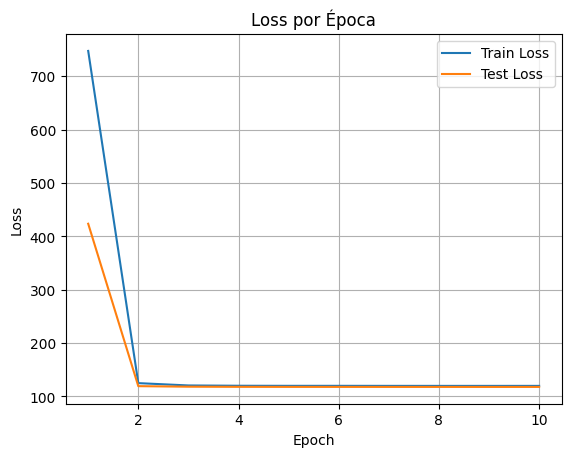

In [ ]:
# IMPLEMENTE AQUI

class normalizaAno(nn.Module):
    def __init__(self, min_year=1922, max_year=2011):
        super().__init__()
        self.min_year = min_year
        self.range = max_year - min_year

    def forward(self, x):
        return x * self.range + self.min_year

lr = 0.00001
epocas = 10
dropout = 0.0
weight_dc = 0.0000000

net = nn.Sequential(
    nn.Linear(90, 64),
    nn.BatchNorm1d(64),
    nn.LeakyReLU(),
    nn.Dropout(dropout),
    nn.Linear(64, 32),
    nn.BatchNorm1d(32),
    nn.LeakyReLU(),
    nn.Dropout(dropout),
    nn.Linear(32, 1),
    nn.Sigmoid(),
    normalizaAno(1922, 2011)
).to(device)

net.apply(weights_init)

loss = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_dc)

train_validate(net, train_iter, test_iter, opt, loss, num_epochs=epocas, type='regression')

In [ ]:
# mostra o resultado predito para as 5 primeiras instâncias de teste
y = net(torch.Tensor(test_features[0:5, :]).to(device))
print(y, test_labels[0:5])

tensor([[1998.0905],
        [1998.2203],
        [1998.2701],
        [1998.1216],
        [1998.4409]], grad_fn=<AddBackward0>) [2008. 2001. 2006. 2008. 1998.]


# Problema 3

Neste problema, você receberá várias *features* (como altura média, inclinação, etc) descrevendo uma região e o modelo deve predizer qual o tipo da região (floresta, montanha, etc). Mais informações sobre esse dataset aqui: https://archive.ics.uci.edu/ml/datasets/covertype

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
!gzip covtype.data.gz
data = np.genfromtxt('covtype.data', delimiter=',', dtype=np.float32)

print(data.shape, data[0, :])
X, y = data[:, :-1], data[:, -1]
print(X.shape, X[0, :])
print(y.shape, y[0])
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.33, random_state=42)
train_labels = train_labels - 1
test_labels = test_labels - 1

batch_size = 100
train_iter = load_array(train_features, train_labels, batch_size)
test_iter = load_array(test_features, test_labels, batch_size, False)

--2025-05-19 13:00:06--  http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘covtype.data.gz’

covtype.data.gz         [      <=>           ]  10.72M  7.35MB/s    in 1.5s    

2025-05-19 13:00:08 (7.35 MB/s) - ‘covtype.data.gz’ saved [11240707]

gzip: covtype.data.gz already has .gz suffix -- unchanged
(581012, 55) [2.596e+03 5.100e+01 3.000e+00 2.580e+02 0.000e+00 5.100e+02 2.210e+02
 2.320e+02 1.480e+02 6.279e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 

In [ ]:
scaler = StandardScaler()

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.20, random_state=42)

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

train_labels = train_labels - 1
test_labels = test_labels - 1

train_iter = load_array(train_features, train_labels, batch_size)
test_iter = load_array(test_features, test_labels, batch_size, False)

In [ ]:
labels =[]

for i in y:
  if i not in labels:
    labels.append(i)

labels.sort()
print(labels)

[np.float32(1.0), np.float32(2.0), np.float32(3.0), np.float32(4.0), np.float32(5.0), np.float32(6.0), np.float32(7.0)]


training on cpu
epoch 1, train loss 0.7780, train acc 0.684, test loss 0.6425, test acc 0.744, time 19.6 sec
epoch 2, train loss 0.5187, train acc 0.783, test loss 0.4599, test acc 0.804, time 18.2 sec
epoch 3, train loss 0.4313, train acc 0.819, test loss 0.4181, test acc 0.823, time 18.3 sec
epoch 4, train loss 0.3964, train acc 0.834, test loss 0.3848, test acc 0.840, time 18.4 sec
epoch 5, train loss 0.3761, train acc 0.843, test loss 0.3709, test acc 0.846, time 17.5 sec
epoch 6, train loss 0.3642, train acc 0.850, test loss 0.3533, test acc 0.853, time 18.4 sec
epoch 7, train loss 0.3537, train acc 0.854, test loss 0.3533, test acc 0.854, time 17.5 sec
epoch 8, train loss 0.3455, train acc 0.857, test loss 0.3480, test acc 0.857, time 17.4 sec
epoch 9, train loss 0.3401, train acc 0.860, test loss 0.3371, test acc 0.862, time 18.4 sec
epoch 10, train loss 0.3357, train acc 0.862, test loss 0.3366, test acc 0.864, time 17.4 sec


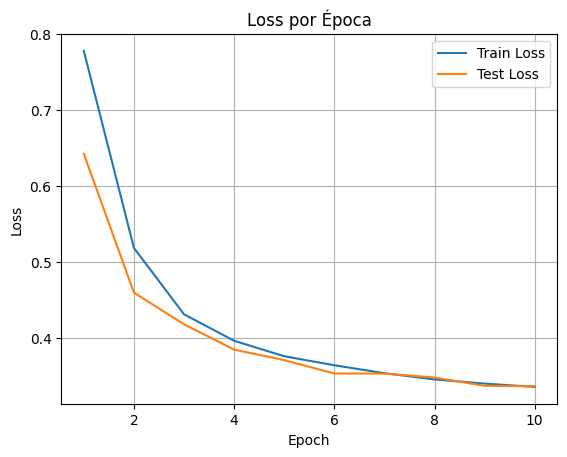

In [ ]:
# IMPLEMENTE AQUI

lr = 0.005
epocas = 10
dropout = 0.5
weight_dc = 0.00001

net = nn.Sequential(
    nn.Linear(54, 64),
    nn.BatchNorm1d(64),
    nn.LeakyReLU(),
    nn.Dropout(dropout),
    nn.Linear(64, 32),
    nn.BatchNorm1d(32),
    nn.LeakyReLU(),
    nn.Dropout(dropout),
    nn.Linear(32, 16),
    nn.BatchNorm1d(16),
    nn.LeakyReLU(),
    nn.Dropout(dropout),
    nn.Linear(16, 7)
).to(device)

net.apply(weights_init)

loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_dc)

train_validate(net, train_iter, test_iter, opt, loss, num_epochs=epocas, type='classification')

# Problema 4

Neste problema, você receberá 11 *features* extraídas de tipos de vinhos, e terá que predizer um *score* para cada vinho. Mais sobre esse dataset aqui: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [ ]:
# download do dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
data_red = np.genfromtxt('winequality-red.csv', delimiter=';', dtype=np.float32, skip_header=1)
data_white = np.genfromtxt('winequality-white.csv', delimiter=';', dtype=np.float32, skip_header=1)
data = np.concatenate((data_red, data_white), axis=0)
data = np.nan_to_num(data)

print(data[0, :])
X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.33, random_state=42)

batch_size = 100
train_iter = load_array(train_features, train_labels, batch_size)
test_iter = load_array(test_features, test_labels, batch_size, False)

--2025-05-19 13:03:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘winequality-red.csv’

winequality-red.csv     [  <=>               ]  82.23K   213KB/s    in 0.4s    

2025-05-19 13:03:31 (213 KB/s) - ‘winequality-red.csv’ saved [84199]

--2025-05-19 13:03:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘winequality-white.csv’

winequality-white.c     [   <=>              ] 258.23K   500KB/s    in 0.5s    

2025-05-19

In [ ]:
scaler = StandardScaler()

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.20, random_state=42)

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

train_labels = train_labels - 3
test_labels = test_labels - 3

train_iter = load_array(train_features, train_labels, batch_size)
test_iter = load_array(test_features, test_labels, batch_size, False)

training on cpu
epoch 1, train loss 1.9367, train acc 0.245, test loss 1.9386, test acc 0.459, time 0.3 sec
epoch 2, train loss 1.9333, train acc 0.431, test loss 1.9263, test acc 0.459, time 0.2 sec
epoch 3, train loss 1.9184, train acc 0.431, test loss 1.9067, test acc 0.459, time 0.2 sec
epoch 4, train loss 1.8832, train acc 0.431, test loss 1.8374, test acc 0.459, time 0.2 sec
epoch 5, train loss 1.6688, train acc 0.431, test loss 1.3847, test acc 0.459, time 0.2 sec
epoch 6, train loss 1.3075, train acc 0.431, test loss 1.2722, test acc 0.459, time 0.2 sec
epoch 7, train loss 1.2795, train acc 0.431, test loss 1.2643, test acc 0.459, time 0.2 sec
epoch 8, train loss 1.2717, train acc 0.431, test loss 1.2556, test acc 0.459, time 0.2 sec
epoch 9, train loss 1.2668, train acc 0.431, test loss 1.2525, test acc 0.459, time 0.2 sec
epoch 10, train loss 1.2632, train acc 0.431, test loss 1.2493, test acc 0.459, time 0.2 sec
epoch 11, train loss 1.2598, train acc 0.431, test loss 1.2467,

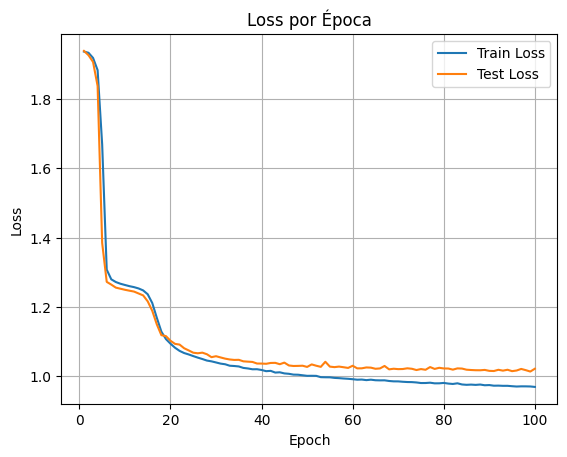

In [ ]:
# IMPLEMENTE AQUI

lr = 0.00005
epocas = 100
dropout = 0.8
weight_dc = 0.05

net = nn.Sequential(
    nn.Linear(11, 128),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(),
    nn.Dropout(dropout),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.LeakyReLU(),
    nn.Dropout(dropout),
    nn.Linear(64, 32),
    nn.BatchNorm1d(32),
    nn.LeakyReLU(),
    nn.Dropout(dropout),
    nn.Linear(32, 16),
    nn.BatchNorm1d(16),
    nn.LeakyReLU(),
    nn.Dropout(dropout),
    nn.Linear(16, 7)
).to(device)

net.apply(weights_init)

loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_dc)

train_validate(net, train_iter, test_iter, opt, loss, num_epochs=epocas, type='classification')

In [ ]:
# mostra o resultado predito para as 5 primeiras instâncias de teste
y = net(torch.Tensor(test_features[0:5, :]).to(device))
print(y, test_labels[0:5])

tensor([[-4.2929, -2.8673,  0.2620,  2.3331,  1.5557, -0.6409, -4.7156],
        [-1.6645,  0.8486,  2.6674,  0.7798, -2.9610, -5.4774, -6.2572],
        [-3.4075, -2.7320, -0.6960,  1.8112,  2.3114,  1.1110, -2.4445],
        [-3.4503, -1.2229,  1.9998,  1.8543, -1.0116, -3.8403, -6.4979],
        [-2.4431, -0.1378,  2.3954,  1.2705, -2.0557, -4.6871, -6.2567]],
       grad_fn=<AddmmBackward0>) [5. 2. 4. 3. 3.]
